## Make a simple synthetic dataset to test hierarchical merge in FOF algorithm

#### the idea is this: 

* after the local FOF stage, each partition reports the particles it holds in the overlap region
* do a reduceByKey or treeAggregate of some sort to collect the groups belonging to the same particles
* produce a mapping of $G -> G_1$ and distribute to all hosts in form of broadcast lookup table

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import sys
sys.setrecursionlimit(sys.getrecursionlimit()*10)

import matplotlib.patches as patches

/Users/rok/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import spark_fof

In [155]:
def plot_rectangle(rec, ax=None):
    if ax is None: 
        ax = plt.subplot(aspect='equal')
    
    if isinstance(rec, (list, tuple)):
        for r in rec: 
            plot_rectangle(r,ax)
    
    else:
        size = (rec.maxes-rec.mins)
        ax.add_patch(patches.Rectangle(rec.mins, size[0], size[1], fill=False, zorder=-1))

In [4]:
import spark_fof_c

## Set up data

In [5]:
import numpy as np

import matplotlib.pylab as plt

%matplotlib inline

import fof

In [40]:
# create the arrays
pdt = np.dtype([('pos','f4', 3), ('iGroup', 'i4'), ('iOrder', 'i4')])
nps = 1000000
ngs = 1
particles = np.zeros(nps, dtype=pdt)
done_ps = 0
#centers = np.random.rand(ngs,3)*1.7 - 0.85
centers = np.array([0,0,0]).reshape(1,3)
for group, center in zip(range(ngs), centers): 
    print group, center
    group_ps = nps/ngs
    if nps - (done_ps + group_ps) < group_ps:
        group_ps = nps - done_ps 
    particles['pos'][done_ps:done_ps+group_ps] = \
        np.random.multivariate_normal(center, [[.5,0,0],[0,.5,0],[0,0,.5]], group_ps)
    done_ps += group_ps
   
particles['iOrder'] = range(nps)

0 [0 0 0]


In [68]:
import pynbody

In [115]:
s = pynbody.load('/Users/rok/Downloads/euclid256.nat')

In [116]:
len(s)

16777216

In [117]:
particles = np.zeros(len(s), dtype=pdt)

In [118]:
particles['pos'] = s['pos']

In [119]:
particles

array([([-0.49415767192840576, -0.49715662002563477, -0.4951761066913605], 0, 0),
       ([-0.4937679171562195, -0.4991474151611328, -0.4966009259223938], 0, 0),
       ([-0.48686617612838745, -0.4905261993408203, -0.4930003881454468], 0, 0),
       ...,
       ([0.4894987642765045, 0.4989055395126343, 0.49769923090934753], 0, 0),
       ([0.4926477372646332, 0.49975159764289856, 0.497660368680954], 0, 0),
       ([0.4963405132293701, 0.49389392137527466, 0.4910287857055664], 0, 0)], 
      dtype=[('pos', '<f4', (3,)), ('iGroup', '<i4'), ('iOrder', '<i4')])

## Start Spark

In [7]:
import findspark
findspark.init()

In [8]:
import os
os.environ['SPARK_CONF_DIR'] = './conf'

In [9]:
import pyspark
from pyspark import SparkContext, SparkConf

In [10]:
conf = SparkConf()

In [11]:
conf.set('spark.python.profile', 'true')
conf.set('spark.executor.memory', '5G')
conf.set('spark.driver.memory', '4G')


In [12]:
sc = SparkContext(master='local[*]', conf=conf, batchSize=0)

In [13]:
sc.addPyFile('spark_fof.py')

## Set up the domains

In [138]:
N = 3
tau = 0.0001
mins = np.array([-.5,-.5,-.5], dtype=np.float)
maxs= np.array([.5,.5,.5], dtype=np.float)
domain_containers = spark_fof.setup_domain(N,tau,maxs,mins)

(-0.5, 0.5)

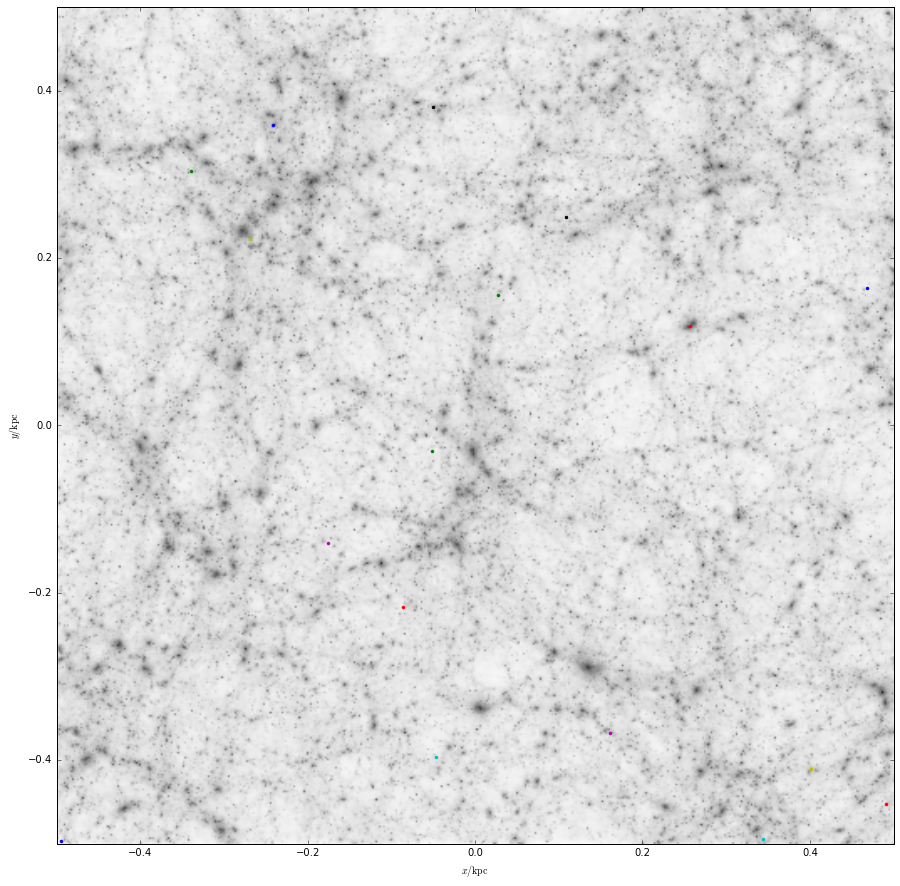

In [158]:
f, ax = plt.subplots(subplot_kw={'aspect':'equal'}, figsize=(15,15))
pynbody.plot.image(s.d, width=1, units = 'Msol Mpc^-2', cmap=plt.cm.Greys, show_cbar=False, subplot=ax)
#plot_rectangle(domain_containers[0].bufferRectangle, ax=ax)
for p in particles[::1000000]: 
    plot_rectangle(domain_containers[spark_fof.get_bin_cython(p['pos'],2**N, np.array(mins), np.array(maxs))], ax=ax)
    plot_rectangle(domain_containers[spark_fof.get_bin_cython(p['pos'], 2**N, np.array(mins),np.array(maxs))].bufferRectangle, ax=ax)
    ax.plot(p['pos'][0], p['pos'][1], '.')
plt.draw()
ax.set_xlim(-.5,.5)
ax.set_ylim(-.5,.5)

### Make the base RDD

In [159]:
p_rdd = sc.parallelize(particles)

### Partition particles into domains and set the partition part of local group ID

In [160]:
# partitioning duplicates the particles that are located in the boundary regions
part_rdd = (p_rdd.mapPartitions(lambda particles: spark_fof.partition_particles_cython(particles, domain_containers, tau))
                 .partitionBy(len(domain_containers))
                 .values())

### Run the local FOF

In [161]:
from spark_util import spark_cython

In [162]:
run_fof = spark_cython('fof', 'run')

In [163]:
def run_local_fof(index, particle_iter, tau): 
    part_arr = np.fromiter(particle_iter, pdt)
    if len(part_arr)>0:
        run_fof(part_arr, tau)
    return part_arr

def set_group_id(partition_index, particle_iter):
    part_arr = np.fromiter(particle_iter, pdt)
    for i in range(len(part_arr)):
        gid = part_arr[i]['iGroup']
        part_arr[i]['iGroup'] = spark_fof.encode_gid(partition_index, gid, 16)
    return part_arr

In [164]:
fof_rdd = part_rdd.mapPartitionsWithIndex(lambda index, particles: run_local_fof(index, particles, tau))\
                  .mapPartitionsWithIndex(set_group_id).cache()

### Group Merging stage

In [165]:
fof_analyzer = spark_fof.FOFAnalyzer(sc, N, tau, fof_rdd)

In [166]:
%time fof_rdd.count()

KeyboardInterrupt: 

In [98]:

particle_rdd = fof_rdd
pg_map = (particle_rdd.mapPartitionsWithIndex(
          lambda index, data: spark_fof.get_buffer_particles(index,
                                                   data,
                                                   domain_containers, 0))
          .map(spark_fof.pid_gid)
          .collectAsMap())

pg_map_b = sc.broadcast(pg_map)

# generate the "local" groups mapping -- this will only link groups among neighboring domains
# this proceeds in a few stages:
#
# 1. filter only the ghost particles and return a (pid, gid) key,value pair RDD
# 2. for each ghost particle pid, aggregate together all of its groups
# 3. from each group list, generate a (g, g') key, value pair RDD where
# g maps onto g'

pg_map_keys = pg_map_b.value.keys()

groups_map = (particle_rdd.repartition(100)
                          .map(spark_fof.pid_gid)
                          .filter(lambda (pid, gid): pid in pg_map_keys)
                          .aggregateByKey([], lambda l, g: l + [g], lambda a, b: sorted(a + b))
                          .values()
                          .flatMap(lambda gs: [(g, gs[0]) for g in gs[1:]])).collect()

In [99]:
sc.show_profiles()

Profile of RDD<id=51>
         2210 function calls in 0.014 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      130    0.003    0.000    0.005    0.000 serializers.py:155(_read_with_length)
      130    0.003    0.000    0.010    0.000 serializers.py:259(dump_stream)
      130    0.001    0.000    0.002    0.000 serializers.py:217(load_stream)
      130    0.001    0.000    0.006    0.000 serializers.py:136(load_stream)
      130    0.001    0.000    0.007    0.000 spark_fof.py:282(get_buffer_particles)
      130    0.001    0.000    0.002    0.000 serializers.py:542(read_int)
      130    0.001    0.000    0.014    0.000 worker.py:104(process)
      130    0.001    0.000    0.001    0.000 {method 'read' of 'file' objects}
      130    0.001    0.000    0.001    0.000 <ipython-input-93-7f27f4b0ef92>:4(<lambda>)
      130    0.000    0.000    0.001    0.000 rdd.py:2345(pipeline_func)
      130    0.000    

In [105]:
s = pynbody.load('/Users/rok/Downloads/euclid256.nat')

/Users/rok/miniconda/lib/python2.7/site-packages/pynbody/snapshot/tipsy.py:130: RuntimeWarning: No readable param file in the run directory or parent directory: using defaults.
  "No readable param file in the run directory or parent directory: using defaults.", RuntimeWarning)


SimArray([[  3.71999424e+08,   4.89018720e+08,   6.35372608e+08, ...,
          1.12290189e+09,   3.44449126e+09,   1.90316365e+09],
       [  4.74561600e+08,   6.37447232e+08,   7.88129024e+08, ...,
          1.02183968e+09,   1.39312141e+09,   9.76401088e+08],
       [  6.83729152e+08,   8.54302208e+08,   9.96793600e+08, ...,
          1.07573530e+09,   1.13343872e+09,   9.71364864e+08],
       ..., 
       [  5.76385856e+08,   8.63969856e+08,   9.70159232e+08, ...,
          1.57020083e+09,   1.09477120e+09,   8.01393856e+08],
       [  6.78310912e+08,   7.61352384e+08,   8.75341120e+08, ...,
          1.27542182e+09,   8.22191296e+08,   6.61504384e+08],
       [  1.25421824e+09,   9.57175680e+08,   8.21560000e+08, ...,
          9.01515136e+08,   9.07677696e+08,   5.65545856e+08]], dtype=float32, 'Msol kpc**-2')

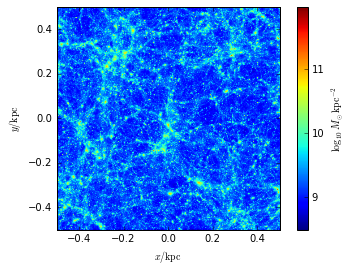

In [114]:
pynbody.plot.image(s.dm, units='Msol kpc^-2', width=1)

In [104]:
merged_rdd = fof_analyzer.merge_groups(0)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job 20 cancelled because Stage 46 was cancelled
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1431)
	at org.apache.spark.scheduler.DAGScheduler.handleJobCancellation(DAGScheduler.scala:1370)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleStageCancellation$1.apply$mcVI$sp(DAGScheduler.scala:1358)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleStageCancellation$1.apply(DAGScheduler.scala:1357)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleStageCancellation$1.apply(DAGScheduler.scala:1357)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofInt.foreach(ArrayOps.scala:156)
	at org.apache.spark.scheduler.DAGScheduler.handleStageCancellation(DAGScheduler.scala:1357)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1613)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1588)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1832)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1845)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1858)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1929)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:927)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:926)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:405)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor81.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)


In [91]:
sc.show_profiles()

Profile of RDD<id=45>
         10567186 function calls (10564674 primitive calls) in 25.700 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  3443964    8.303    0.000    8.303    0.000 spark_fof_c.pyx:107(in_rectangle_cython)
  1721982    8.096    0.000   16.399    0.000 spark_fof_c.pyx:53(rect_buffer_zone_cython)
  1721982    4.071    0.000   22.407    0.000 spark_fof.py:410(in_buffer_zone)
     4468    1.453    0.000    1.453    0.000 {cPickle.loads}
     8917    1.255    0.000   25.379    0.003 spark_fof.py:282(get_buffer_particles)
  1721982    0.760    0.000   18.336    0.000 spark_util.py:4(wrapped)
  1721982    0.636    0.000   17.035    0.000 {spark_fof_c.rect_buffer_zone_cython}
     4096    0.091    0.000   25.575    0.006 serializers.py:259(dump_stream)
    13032    0.087    0.000    0.087    0.000 {method 'read' of 'file' objects}
      404    0.083    0.000    0.083    0.000 {cPickle.dumps}
  

In [27]:
merged = merged_rdd.collect()

In [28]:
merged_arr = np.fromiter(merged, pdt)

In [29]:
groups = np.unique(merged_arr['iGroup'])

In [30]:
groups

array([ 25231360, 145162240, 172359680, 175898624, 194576384], dtype=int32)

25231360 25663
145162240 26684
172359680 23267
175898624 26228
194576384 25449


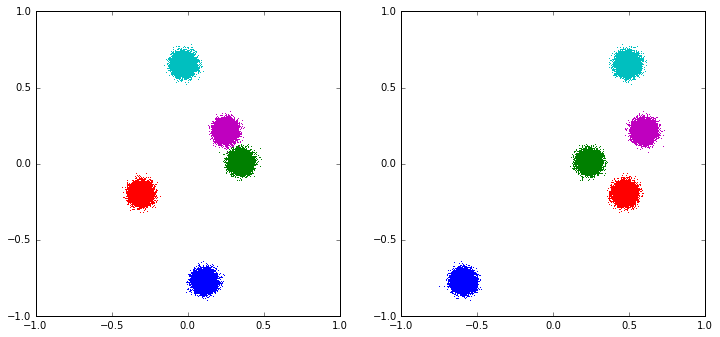

In [31]:
f, axs = plt.subplots(1,2, subplot_kw={'aspect':'equal'}, figsize=(12,12))
for group in groups: 
    inds = np.where(merged_arr['iGroup'] == group)[0]
    print group, len(inds)
    axs[0].plot(merged_arr['pos'][inds,1], merged_arr['pos'][inds,0], ',')
    axs[1].plot(merged_arr['pos'][inds,2], merged_arr['pos'][inds,0], ',')
for ax in axs:
    ax.set_xlim(-1,1); ax.set_ylim(-1,1)

In [33]:
sc.show_profiles()

Profile of RDD<id=7>
         18430252 function calls (18422060 primitive calls) in 36.468 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   350089   11.459    0.000   11.459    0.000 {cPickle.dumps}
   533668    3.209    0.000    6.126    0.000 spark_fof_c.pyx:53(rect_buffer_zone_cython)
  1067336    2.917    0.000    2.917    0.000 spark_fof_c.pyx:106(in_rectangle_cython)
   704274    1.846    0.000   14.734    0.000 rdd.py:1697(add_shuffle_key)
  1400356    1.749    0.000    1.749    0.000 {method 'write' of 'file' objects}
   533668    1.523    0.000    8.176    0.000 spark_fof.py:412(in_buffer_zone)
   700178    1.513    0.000    4.583    0.000 serializers.py:143(_write_with_length)
   388318    1.384    0.000    3.181    0.000 copy.py:145(deepcopy)
   388318    1.127    0.000    1.224    0.000 copy.py:267(_keep_alive)
   388318    1.005    0.000    1.005    0.000 spark_fof.py:297(pid_gid)
     4096  

In [77]:
%time run_fof(particles, 0.0001)

CPU times: user 38.3 s, sys: 34.6 ms, total: 38.3 s
Wall time: 38.3 s


2877